In [10]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from transformers import RobertaModel, RobertaTokenizer, get_linear_schedule_with_warmup, AdamW
from sklearn.metrics import f1_score
import shap
import matplotlib.pyplot as plt

In [21]:
# Load the CSV file
def load_data(file_path):
    df = pd.read_csv(file_path)
    texts = df["text"].tolist()
    labels = df[["anger", "fear", "joy", "sadness", "surprise"]].values
    return texts, labels

# Load train and test data
train_file = "Emotion_data/public_data_test/track_a/train/eng.csv"
dev_file = "Emotion_data/public_data_test/track_a/dev/eng.csv"
test_file = "Emotion_data/public_data_test/track_a/test/eng.csv"
human_pred = "Emotion_data/eng_test_50 labels.csv"

train_texts, train_labels = load_data(train_file)
dev_texts, dev_labels = load_data(dev_file)
test_texts, test_labels = load_data(test_file)
h_texts, h_labels = load_data(human_pred)

# Initialize tokenizer
tokenizer = RobertaTokenizer.from_pretrained("roberta-large")

# Find the max token length dynamically
def find_max_length(texts, tokenizer):
    tokenized_texts = [tokenizer.tokenize(text) for text in texts]
    return max(len(tokens) for tokens in tokenized_texts)

max_length = find_max_length(train_texts + test_texts, tokenizer)  # Find max length from both train & test
print(f"Dynamic max length: {max_length}")

# Tokenize with dynamic max_length
def tokenize_texts(texts, tokenizer, max_length):
    return tokenizer(
        texts,
        max_length=max_length,
        truncation=True,
        padding="max_length",
        return_tensors="pt",
    )

train_encodings = tokenize_texts(train_texts, tokenizer, max_length)
dev_encodings = tokenize_texts(dev_texts, tokenizer, max_length)
test_encodings = tokenize_texts(test_texts, tokenizer, max_length)
h_encodings = tokenize_texts(h_texts, tokenizer, max_length)

Dynamic max length: 110


In [14]:
# Dataset class
class EmotionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return {
            "input_ids": self.encodings["input_ids"][idx],
            "attention_mask": self.encodings["attention_mask"][idx],
            "labels": torch.tensor(self.labels[idx], dtype=torch.float),
        }

# Create datasets
train_dataset = EmotionDataset(train_encodings, train_labels)
dev_dataset = EmotionDataset(dev_encodings, dev_labels)
test_dataset = EmotionDataset(test_encodings, test_labels)
h_dataset = EmotionDataset(h_encodings, h_labels)


# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


In [15]:
class RobertaClass(torch.nn.Module):
    def __init__(self, num_labels=5):
        super(RobertaClass, self).__init__()
        self.roberta = RobertaModel.from_pretrained("roberta-large")
        self.dropout = torch.nn.Dropout(0.3)

         # Additional fully connected layers
        self.fc1 = torch.nn.Linear(1024, 512)
        self.fc2 = torch.nn.Linear(512, num_labels)

    def forward(self, input_ids, attention_mask):
        # Get the output from Roberta
        output = self.roberta(input_ids=input_ids, attention_mask=attention_mask)

        cls_output = output[0][:, 0, :]  # (batch_size, hidden_size) - [CLS] token representation

        # Apply dropout for regularization
        cls_output = self.dropout(cls_output)

        # Pass through the first fully connected layer
        x = torch.nn.ReLU()(self.fc1(cls_output))

        # Apply dropout after the fully connected layer
        x = self.dropout(x)

        # Final output layer for classification
        logits = self.fc2(x)

        return logits


In [ ]:
#Training the Roberta model
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")

epochs = 20

model = RobertaClass(num_labels=5)
model.to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8, weight_decay=1e-3)  # Adjusted learning rate
criterion = torch.nn.BCEWithLogitsLoss()

# Scheduler for learning rate decay
warmup_ratio = 0.1  # 10% of total training as warmup
total_steps = len(train_loader) * epochs
warmup_steps = int(total_steps * warmup_ratio)

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)

best_loss = float('inf')

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = model(input_ids, attention_mask)

        # Compute loss
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        scheduler.step()  # Update the learning rate based on the scheduler

        total_loss += loss.item()


    # Print training loss
    print(f"Epoch {epoch+1}/{epochs}, Loss: {total_loss / len(train_loader)}")

    # Save the best model based on loss
    if total_loss < best_loss:
        best_loss = total_loss
        torch.save(model.state_dict(), "best_model.pt")

# Load the best model for evaluation
model.load_state_dict(torch.load("best_model.pt"))


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/home/bhra451f/.conda/envs/SemEval/lib/python3.13/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Epoch 1/20, Loss: 0.5785464017377423
Epoch 2/20, Loss: 0.4053634816856054
Epoch 3/20, Loss: 0.3126654745957066
Epoch 4/20, Loss: 0.22486786189020713
Epoch 5/20, Loss: 0.16152142268212544
Epoch 6/20, Loss: 0.10660705753639771
Epoch 7/20, Loss: 0.07348340036175241
Epoch 8/20, Loss: 0.05557230722449849
Epoch 9/20, Loss: 0.040043652660584864
Epoch 10/20, Loss: 0.025424654331768867
Epoch 11/20, Loss: 0.024165811880513206
Epoch 12/20, Loss: 0.013389948796550878
Epoch 13/20, Loss: 0.008618564357391606
Epoch 14/20, Loss: 0.007726972375934502
Epoch 15/20, Loss: 0.0075498565570841615
Epoch 16/20, Loss: 0.004976064788387561
Epoch 17/20, Loss: 0.005387922700641225
Epoch 18/20, Loss: 0.003472040692005156
Epoch 19/20, Loss: 0.0035766657482902654
Epoch 20/20, Loss: 0.0031993960542133285


/tmp/ipykernel_933215/3682864175.py:58: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_model.pt"))


<All keys matched successfully>

In [ ]:
# Evaluation
model.eval()
all_preds = []
all_labels = []
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for batch in dev_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask)

        # Apply sigmoid and threshold to get binary predictions
        preds = (torch.sigmoid(outputs) > 0.5).float()  # Threshold at 0.5 for multi-label

        # Collect predictions and labels for F1 score
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Flatten lists and calculate F1 score
all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

# Calculate F1 score for each label individually
f1_per_label = f1_score(all_labels, all_preds, average=None)  # F1 score for each label
print("Validation F1 Score per label (with dev data):")
for idx, score in enumerate(f1_per_label):
    print(f"Label {idx} F1 Score: {score:.4f}")


Validation F1 Score per label (with dev data):
Label 0 F1 Score: 0.7742
Label 1 F1 Score: 0.8244
Label 2 F1 Score: 0.7451
Label 3 F1 Score: 0.8169
Label 4 F1 Score: 0.7692


In [ ]:
# Evaluation with human predictions
model.eval()
all_preds = []
all_labels = []
test_loss = 0.0
correct = 0
total = 0

h_loader = DataLoader(h_dataset, batch_size=8, shuffle=False)

with torch.no_grad():
    for batch in h_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["labels"].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask)

        # Apply sigmoid and threshold to get binary predictions
        preds = (torch.sigmoid(outputs) > 0.5).float()  # Threshold at 0.5 for multi-label

        # Collect predictions and labels for F1 score
        all_preds.append(preds.cpu().numpy())
        all_labels.append(labels.cpu().numpy())

# Flatten lists and calculate F1 score
all_preds = np.vstack(all_preds)
all_labels = np.vstack(all_labels)

# Calculate F1 score for each label individually
f1_per_label = f1_score(all_labels, all_preds, average=None)  # F1 score for each label
print("F1 Score per label (with human prediction):")
for idx, score in enumerate(f1_per_label):
    print(f"Label {idx} F1 Score: {score:.4f}")


F1 Score per label (with human prediction):
Label 0 F1 Score: 0.4000
Label 1 F1 Score: 0.6383
Label 2 F1 Score: 0.6667
Label 3 F1 Score: 0.6400
Label 4 F1 Score: 0.5185


In [ ]:
# Predict the labels for test data and Store
predictions = []

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)

        outputs = model(input_ids, attention_mask)
        preds = torch.sigmoid(outputs).cpu().numpy()
        binary_preds = (preds >= 0.5).astype(int)  # Apply thresholding
        predictions.extend(binary_preds)

# Convert predictions to DataFrame
test_df = pd.read_csv(test_file)  # Load the original test file to get the text
preds_df = pd.DataFrame(predictions, columns=["anger", "fear", "joy", "sadness", "surprise"])
output_df = pd.concat([test_df["text"], preds_df], axis=1)

# Save to CSV
output_df.to_csv("test_predictions.csv", index=False)
print("Binary predictions saved to test_predictions.csv")

Binary predictions saved to test_predictions.csv


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
<ipython-input-19-7bb796b7dc45>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recom

  0%|          | 0/498 [00:00<?, ?it/s]

PartitionExplainer explainer: 4it [00:10, 10.12s/it]               


 Sample 1: / o \ So today I went in for a new exam with Dr. Polvi today, I had to file new paperwork for the automobile accident case which is being done differently then the scoliosis stuff.So he comes in and starts talking about insurance stuff and how this look bad since I was getting treatment on my neck and stuff already blah blah.



 Sample 2: The image I have in my mind is this: a group of well-meaning vaguely sadistic folks digging a deep pit in my heart and mind that can only be filled with fear.



 Sample 3: I slammed my fist against the door and yelled, Open up!



 SHAP Bar Plot for 'anger'


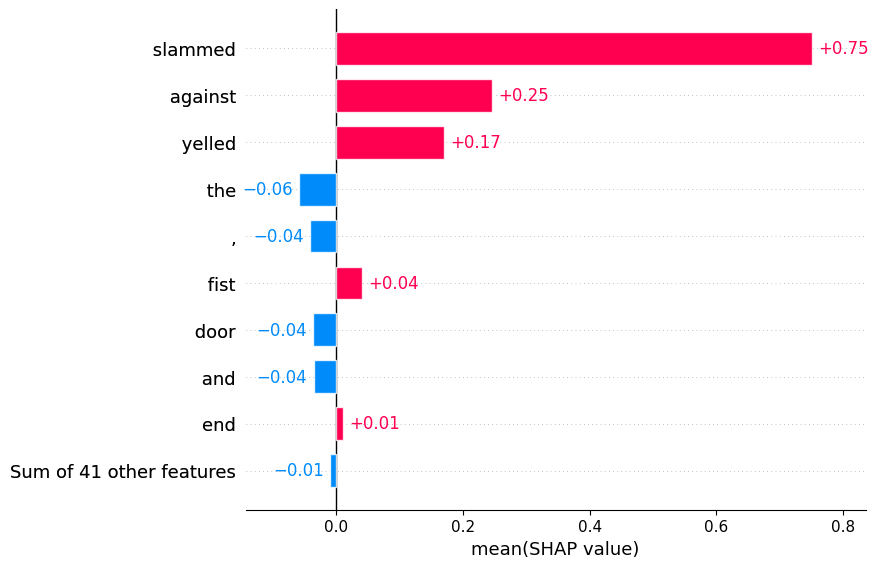


 SHAP Bar Plot for 'fear'


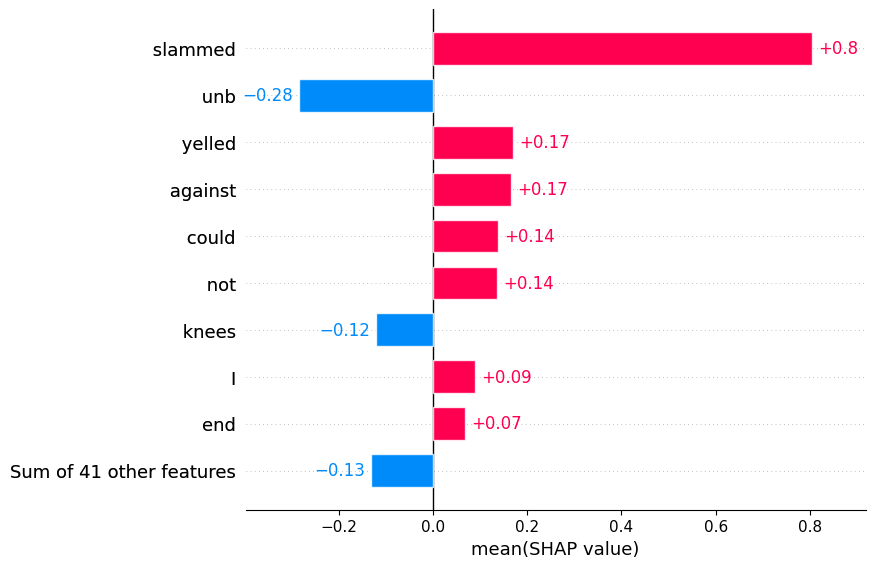


 SHAP Bar Plot for 'joy'


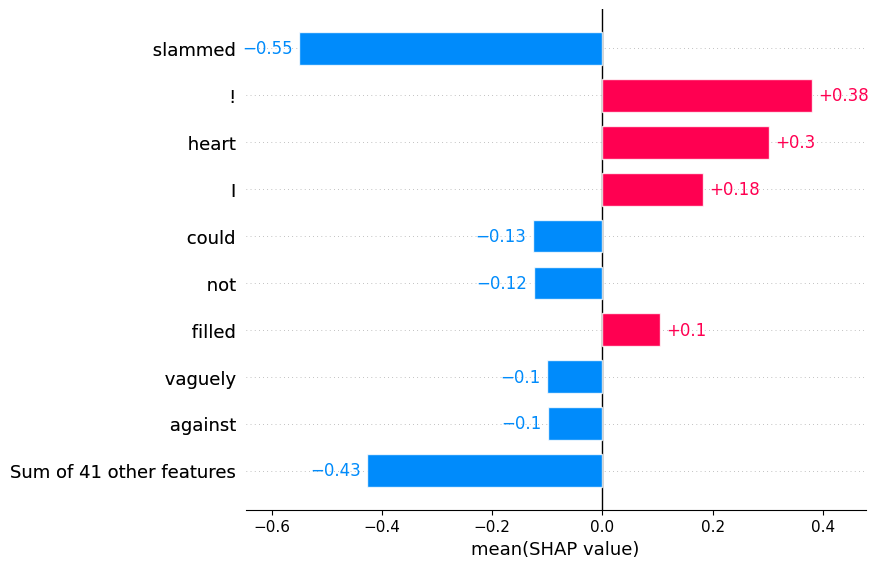


 SHAP Bar Plot for 'sadness'


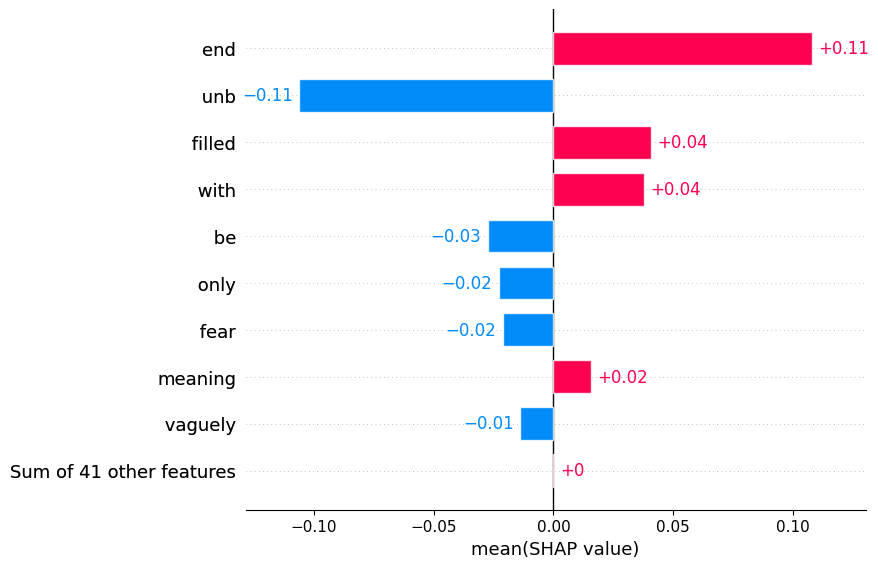


 SHAP Bar Plot for 'surprise'


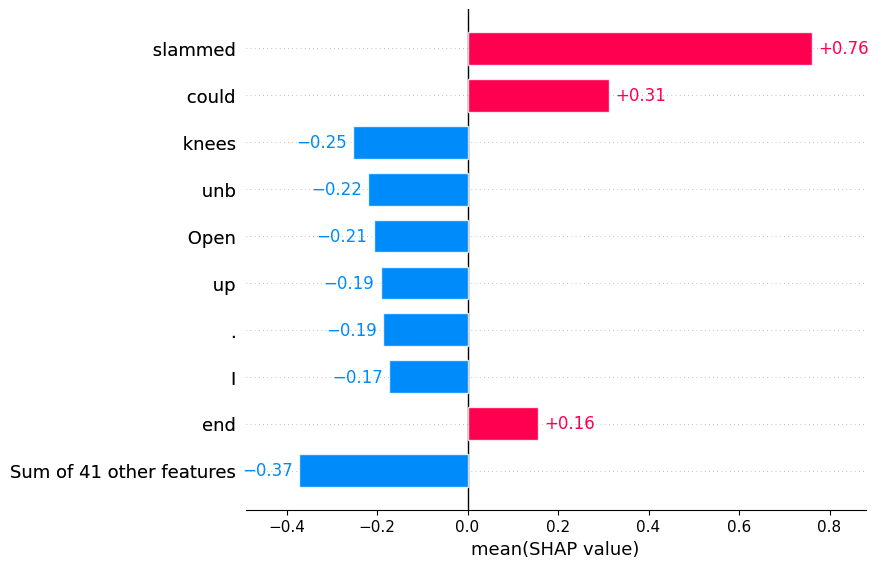

In [19]:
#SHAP
device = torch.device("cuda:7" if torch.cuda.is_available() else "cpu")
model = RobertaClass(num_labels=5)  # Your model class
model.load_state_dict(torch.load("best_model.pt"), strict=False)  # Load trained weights
model.to(device)
model.eval()

class ModelWrapper:
    def __init__(self, model, tokenizer):
        self.model = model
        self.tokenizer = tokenizer

    def __call__(self, input_texts):
        """ Tokenizes text and runs through the model for SHAP """
        if isinstance(input_texts, np.ndarray):
            input_texts = input_texts.tolist()

        # Ensure input_texts is a List[str]
        input_texts = [str(text) for text in input_texts]

        encodings = self.tokenizer(
            input_texts, padding=True, truncation=True, max_length=64, return_tensors="pt"
        ).to(device)

        with torch.no_grad():
            outputs = self.model(encodings["input_ids"], encodings["attention_mask"])

        return torch.sigmoid(outputs).cpu().numpy()  # Convert logits to probabilities

# Use a SHAP Masker for Token-based Models
masker = shap.maskers.Text(tokenizer, collapse_mask_token="")

wrapper = ModelWrapper(model, tokenizer)

#Initialize SHAP Explainer with Text Masker
explainer = shap.Explainer(wrapper, masker)


sample_size = 5
sample_texts = []


# Take sample texts from test data into a list
sample_texts = [str(text) for text in test_texts[:10]]
shap_values = explainer(sample_texts[1:4])

# Define your label names as per your dataset
label_names = ["anger", "fear", "joy", "sadness", "surprise"]  # Update based on your labels

shap_values.output_names = label_names  # Replace SHAP output with actual labels

plt.style.use('default')

for i in range(len(shap_values)):
    print(f"Sample {i+1}: {sample_texts[i]}")
    shap_output = shap_values[i]
    # Clean the SHAP output by removing "Ġ" characters
    shap_output.data = [token.replace("Ġ", " ") for token in shap_output.data]
    shap.plots.text(shap_output, display=True)

# Clean the feature names in shap_values
shap_values.feature_names = [
    [token.replace("Ġ", " ") for token in tokens]
    for tokens in shap_values.feature_names
]

# Loop through each label and generate the SHAP bar plot
for label in label_names:
    print(f"\n SHAP Bar Plot for '{label}'")
    shap.plots.bar(shap_values[:, :, label].mean(0))

